**Let's tackle the dataset number 2 videos_commented_daily.parquet:  which highlights the number of videos commented by users per day with the date**

In [ ]:
##Code to load data and convert it to csv

# import pandas as pd

# # Load the Parquet file
# file_path = 'data/videos_commented_daily.parquet'
# data = pd.read_parquet(file_path)

# # Save it as a CSV file
# data.to_csv('videos_commented_daily.csv', index=False)

**Now let's investigate how many videos do "bots" comment each day across time to detect trends** so overall the year we want the number of comments / the number of bots that commented that day

In [61]:
import pandas as pd



# Group by upload_date and aggregate
result = data.groupby('upload_date').agg(
    videos_commented=('videos_commented', 'sum'),
    distinct_bots=('author', 'nunique')
).reset_index()

# Calculate comments per bot
result['comments_per_bot'] = result['videos_commented'] / result['distinct_bots']

result.head()


,upload_date,videos_commented,distinct_bots,comments_per_bot
0,2018-01-01,6788,548,12.386861
1,2018-01-02,12018,973,12.351490
2,2018-01-03,13573,1052,12.902091
3,2018-01-04,14417,1144,12.602273
4,2018-01-05,14046,1130,12.430088


In [31]:
data.head()

,author,videos_commented,upload_date
0,1695,10,2018-04-21
1,1695,10,2018-04-28
2,1695,10,2018-05-12
3,1695,10,2018-05-15
4,1695,11,2018-05-17


In [18]:
# Check the total number of distinct bots in the original dataset
total_distinct_bots = data['author'].nunique()
print("Total number of distinct bots:", total_distinct_bots)

Total number of distinct bots: 119906


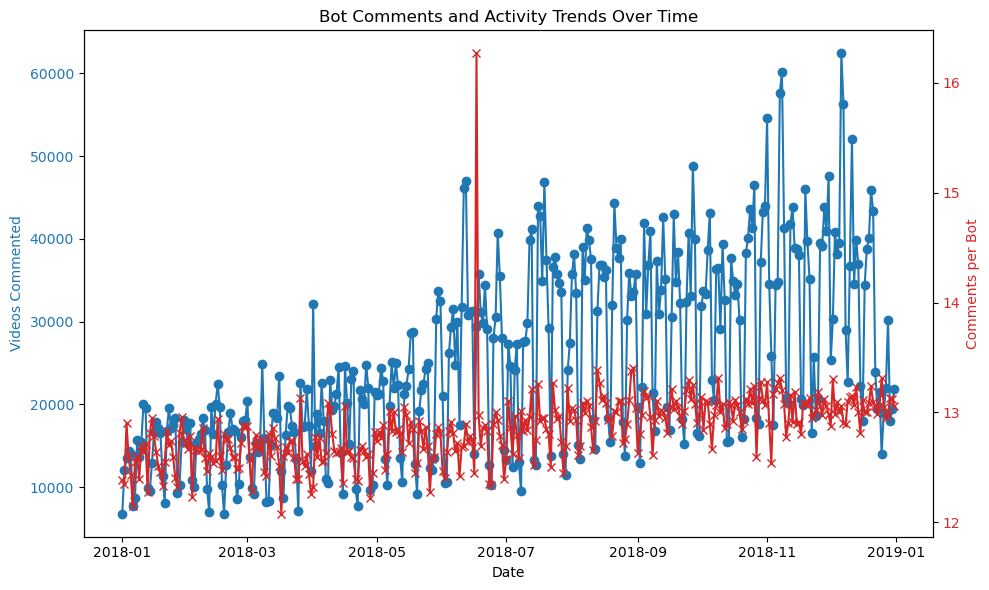

In [62]:
import matplotlib.pyplot as plt

# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot videos commented
ax1.plot(result['upload_date'], result['videos_commented'], color='tab:blue', label='Videos Commented', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Videos Commented', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second y-axis to plot comments per bot
ax2 = ax1.twinx()
ax2.plot(result['upload_date'], result['comments_per_bot'], color='tab:red', label='Comments per Bot', marker='x')
ax2.set_ylabel('Comments per Bot', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and layout adjustments
plt.title('Bot Comments and Activity Trends Over Time')
fig.tight_layout()  # Adjust layout to fit everything
plt.xticks(rotation=45)

# Show the plot
plt.show()


From this first graph we see that the amounts of comments made by suspicious users increased during the year 2018. Now let's see how it looks by weeks.

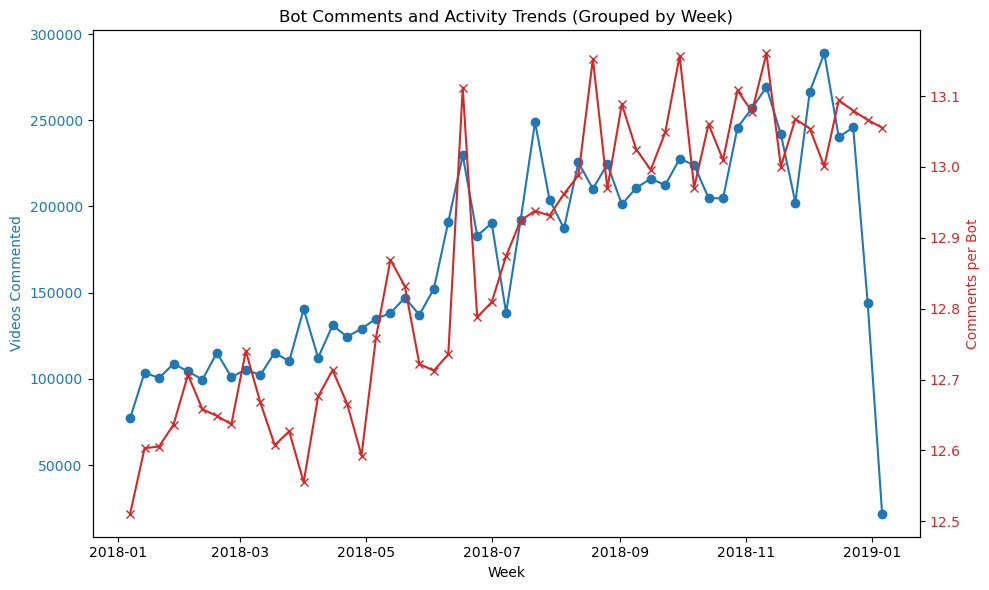

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'upload_date' is in datetime format
result['upload_date'] = pd.to_datetime(result['upload_date'])

# Group by week
result_weekly = result.groupby(pd.Grouper(key='upload_date', freq='W')).agg(
    videos_commented=('videos_commented', 'sum'),
    distinct_bots=('distinct_bots', 'sum')  # Use sum for distinct_bots
).reset_index()

# Calculate comments per bot per week
result_weekly['comments_per_bot'] = result_weekly['videos_commented'] / result_weekly['distinct_bots']

# Plot the weekly data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot videos commented per week
ax1.plot(result_weekly['upload_date'], result_weekly['videos_commented'], color='tab:blue', label='Videos Commented (Weekly)', marker='o')
ax1.set_xlabel('Week')
ax1.set_ylabel('Videos Commented', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second y-axis to plot comments per bot per week
ax2 = ax1.twinx()
ax2.plot(result_weekly['upload_date'], result_weekly['comments_per_bot'], color='tab:red', label='Comments per Bot (Weekly)', marker='x')
ax2.set_ylabel('Comments per Bot', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and layout adjustments
plt.title('Bot Comments and Activity Trends (Grouped by Week)')
fig.tight_layout()  # Adjust layout to fit everything
plt.xticks(rotation=45)

# Show the plot
plt.show()

We get confirmation of the trend in a clearer way. Both the number of videos commented by suspicious users and the avaerage number of videos commented by suspicious users increased. 

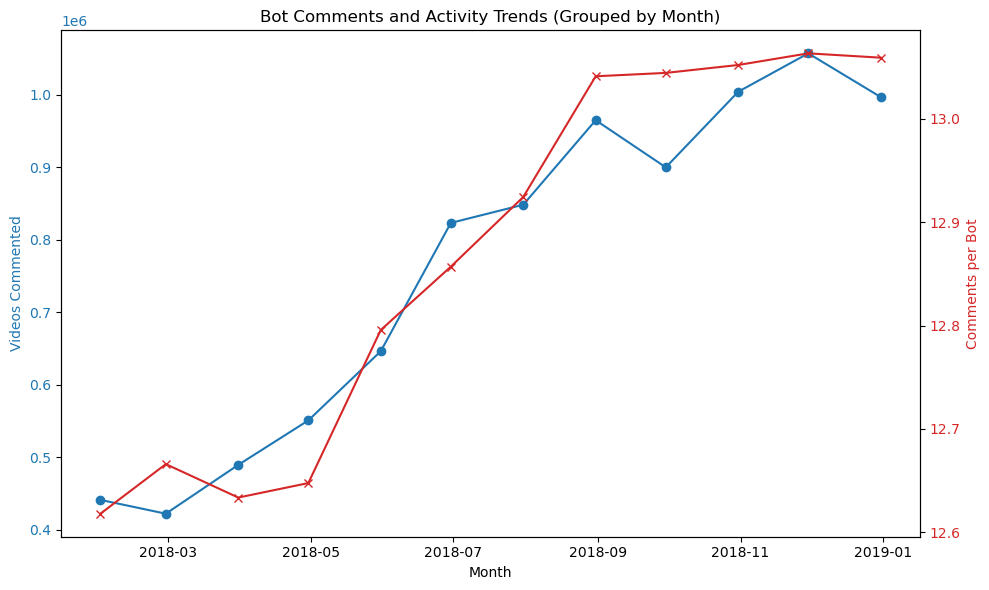

In [14]:
# Group by month
result_monthly = result.groupby(pd.Grouper(key='upload_date', freq='M')).agg(
    videos_commented=('videos_commented', 'sum'),
    distinct_bots=('distinct_bots', 'sum')  # Use sum for distinct_bots
).reset_index()

# Calculate comments per bot per month
result_monthly['comments_per_bot'] = result_monthly['videos_commented'] / result_monthly['distinct_bots']

# Plot the monthly data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot videos commented per month
ax1.plot(result_monthly['upload_date'], result_monthly['videos_commented'], color='tab:blue', label='Videos Commented (Monthly)', marker='o')
ax1.set_xlabel('Month')
ax1.set_ylabel('Videos Commented', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second y-axis to plot comments per bot per month
ax2 = ax1.twinx()
ax2.plot(result_monthly['upload_date'], result_monthly['comments_per_bot'], color='tab:red', label='Comments per Bot (Monthly)', marker='x')
ax2.set_ylabel('Comments per Bot', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and layout adjustments
plt.title('Bot Comments and Activity Trends (Grouped by Month)')
fig.tight_layout()  # Adjust layout to fit everything
plt.xticks(rotation=45)

# Show the plot
plt.show()

With this plot segmented by month we don't see the "noise" due to the different days or weeks of the year which were making the trend harder to see. Let's see if there is a big difference in the number of comments made by suspicious users depending on the weekday. 

Now we want to see if we have a higher number of suspicious user commenting, and higher number of comments by suspicious users on some specific dates of the year and let's see if the correlate with a particular event which impacted the poeple. Since we have an english dataset, looking at trends in english speaking countries. Find a calendar with biggest events in 2018 to see correlations? 


***Analyzing Bot Lifetime Based on Commenting Frequency***

In this analysis, we aim to understand the typical "lifetime" of bots—how long they remain active in terms of commenting—before they stop commenting altogether. Specifically, we’ll explore:

Bot Activity Duration:

*Lifetime Definition*: We define a bot’s lifetime as the number of days it remains active in commenting. We’ll analyze the duration from a bot’s first recorded comment to its last known activity.

**Influence of Commenting Frequency on Lifetime**:

*Average Daily Comments*: We’ll group bots based on their average number of comments per day. By segmenting bots by this metric, we can determine if higher daily commenting activity correlates with a shorter or longer active period.

*Activity Patterns*: This analysis may reveal if highly active bots (those commenting on many videos per day) tend to have shorter lifespans, possibly due to detection and removal, while lower-activity bots might go unnoticed for longer.
These insights will provide a clearer picture of bot behavior longevity and how activity levels influence a bot’s lifecycle.

count    119906.000000
mean         52.699339
std          88.530296
min           1.000000
25%           1.000000
50%           1.000000
75%          68.000000
max         365.000000
Name: lifetime_days, dtype: float64


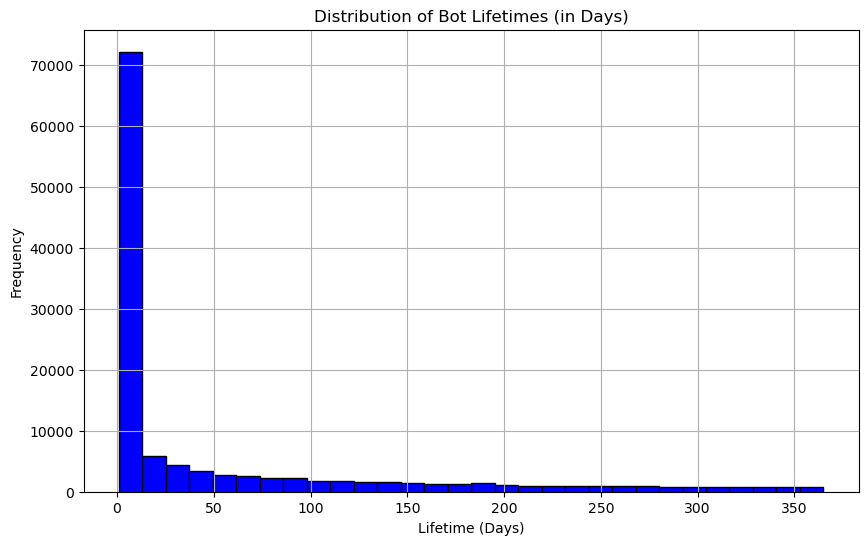

In [105]:
## 1st step : BOT ACTIVITY DURATION
# 
# First, identify the first and last comment date for each bot
bot_activity = data.groupby('author')['upload_date'].agg(['min', 'max'])

# Calculate the lifetime of each bot (in days)
bot_activity['lifetime_days'] = (bot_activity['max'] - bot_activity['min']).dt.days +1

# Display the lifetime distribution
print(bot_activity['lifetime_days'].describe())

# Optional: Plot the distribution of bot lifetimes
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(bot_activity['lifetime_days'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Bot Lifetimes (in Days)')
plt.xlabel('Lifetime (Days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**Better way to visualize: segmenting by categories:**

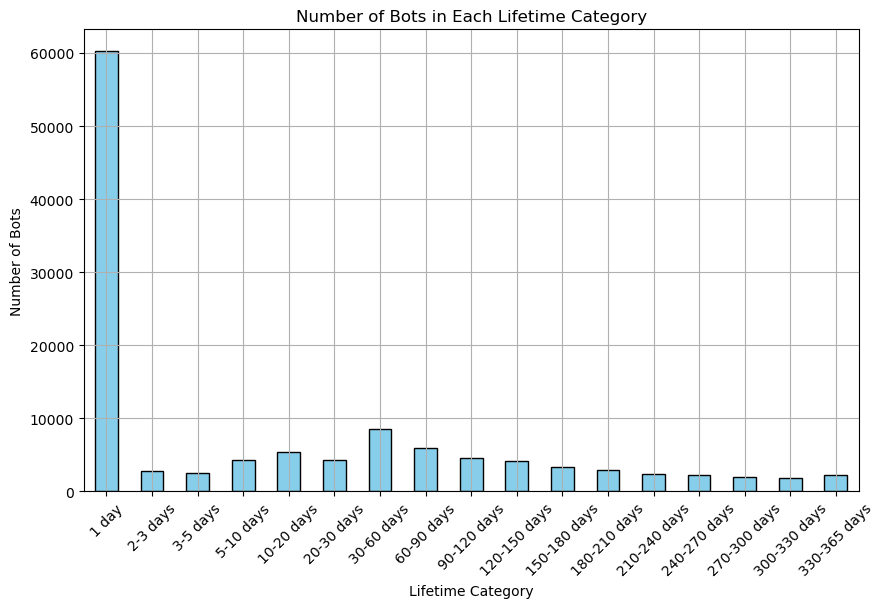

Counts of bots in each lifetime category:
lifetime_category
1 day           60227
2-3 days         2741
3-5 days         2573
5-10 days        4318
10-20 days       5443
20-30 days       4285
30-60 days       8596
60-90 days       5881
90-120 days      4536
120-150 days     4172
150-180 days     3321
180-210 days     2931
210-240 days     2434
240-270 days     2296
270-300 days     1982
300-330 days     1839
330-365 days     2274
Name: count, dtype: int64
pourcentage of bots per lifetimes categories:
lifetime_category
1 day           50.252401
2-3 days         2.287045
3-5 days         2.146868
5-10 days        3.602867
10-20 days       4.541548
20-30 days       3.575332
30-60 days       7.172359
60-90 days       4.907008
90-120 days      3.784762
120-150 days     3.481047
150-180 days     2.770987
180-210 days     2.445577
210-240 days     2.030889
240-270 days     1.915744
270-300 days     1.653748
300-330 days     1.534431
330-365 days     1.897388
Name: count, dtype: float64


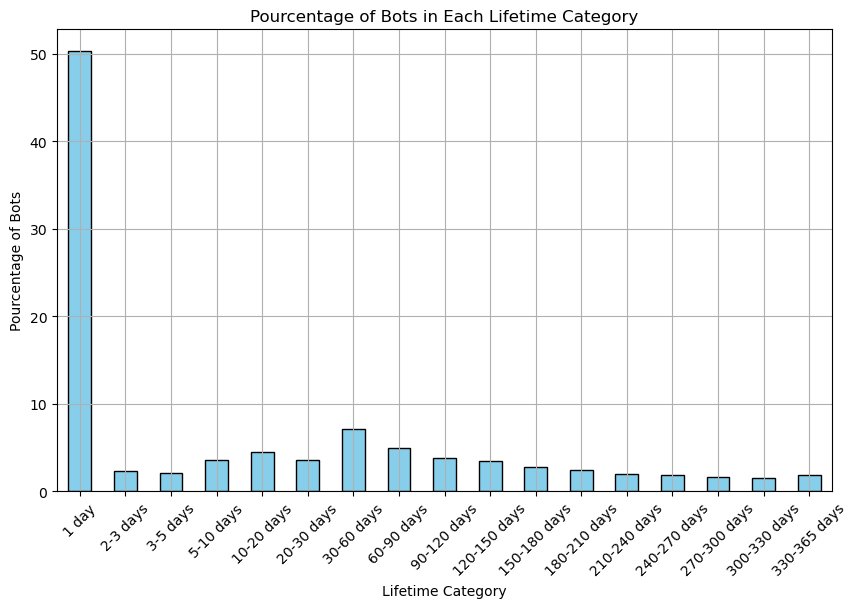

In [109]:
#Define the bins for bot lifetimes
bins = [1,2, 3, 5, 10, 20, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]
labels = ['1 day','2-3 days', '3-5 days', '5-10 days', '10-20 days', '20-30 days', 
          '30-60 days', '60-90 days', '90-120 days', '120-150 days', '150-180 days', 
          '180-210 days', '210-240 days', '240-270 days', '270-300 days', '300-330 days', 
          '330-365 days']

# Step 3: Categorize bots based on their lifetime
bot_activity['lifetime_category'] = pd.cut(bot_activity['lifetime_days'], bins=bins, labels=labels, right=False)

# Step 4: Count the number of bots in each lifetime category
lifetime_counts = bot_activity['lifetime_category'].value_counts().sort_index()

# Step 5: Plot the counts of bots in each lifetime category
plt.figure(figsize=(10, 6))
lifetime_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Bots in Each Lifetime Category')
plt.xlabel('Lifetime Category')
plt.ylabel('Number of Bots')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Step 6: Print the counts for each category
print("Counts of bots in each lifetime category:")
print(lifetime_counts)

print("pourcentage of bots per lifetimes categories:")
pourcentages_of_lifetime_categories= (lifetime_counts / lifetime_counts.sum()*100)
print(pourcentages_of_lifetime_categories)

plt.figure(figsize=(10, 6))
pourcentages_of_lifetime_categories.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Pourcentage of Bots in Each Lifetime Category')
plt.xlabel('Lifetime Category')
plt.ylabel('Pourcentage of Bots')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

We can conclude that 50% of users we considered bots are just commenting on 10 different videos(which was the filter condition)during 1 day on the data from 2018, maybe they are still active the rest of the year but they were not considered "suspicious" the rest of the time by our filter. This raises few hypothesis that we need to further investigate during the rest of the Project:
1) Are they really bots or just a normal user that was really active over the course of 1 day ? 
2) Were these bots that were patched ? 

To investigate we can also analyse the relation between having a given "lifetime" with respect to the number of comments per day. (We remind you that here in this dataset we created, we only have the days were the author wrote more or equal to 10 comments). 
Let's see !



In [ ]:
bot_activity.head()

,min,max,lifetime_days,lifetime_category
author,,,,
1695,2018-04-21,2018-11-06,199,180-210 days
8417,2018-06-12,2018-06-12,0,0-1 day
9490,2018-05-04,2018-07-27,84,60-90 days
11164,2018-05-25,2018-05-25,0,0-1 day
17554,2018-07-25,2018-08-10,16,10-20 days


To check if there is a relation we first need to create categories for the type of behaviors of each users. We mean that we will segment based on the average number of comments per day. 

In [ ]:
# # Group by 'author' and sum the 'videos_commented' column for each user
# comments_per_user = data.groupby('author')['videos_commented'].sum().reset_index()

# # Rename the column to 'total_comments_year2018'
# comments_per_user.rename(columns={'videos_commented': 'total_comments_year2018'}, inplace=True)

# comments_per_user.head()
# Assuming 'data' contains 'author', 'videos_commented', 'upload_date'
# Convert 'upload_date' to datetime if it's not already in datetime format
data['upload_date'] = pd.to_datetime(data['upload_date'])

# Step 1: Create the 'comments_per_user' table (total comments per user)
comments_per_user = data.groupby('author')['videos_commented'].sum().reset_index()

# Rename the column to 'total_comments_year2018'
comments_per_user.rename(columns={'videos_commented': 'total_comments_year2018'}, inplace=True)


#FALSE: here we should divide by the number of days where it overtook 10 comments/per day. Which means that for each users we need to count for how many days they were suspicious throughout 2018 and then join this table using the column author and then use the new column of the merge to compute the average number of comments per number of days where it was suspicious. This column will replace :  merged_data['lifetime_days'] in the division

# number_of_suspicous_days_per_users= data.groupby('author').count(author)


# Group the data by author and count the number of suspicious days: here we use >=10 but we could just count them, but it was implemented like that so later we can reuse it with full dataset
suspicious_days = data.groupby('author').apply(lambda x: (x['videos_commented'] >= 10).sum())
suspicious_days = suspicious_days.reset_index(name='suspicious_days')

# Merge the DataFrames on the 'author' column
merged_data = pd.merge(comments_per_user, suspicious_days, on='author')

# Calculate the average comments per suspicious day
merged_data['avg_comments_per_suspicious_day'] = merged_data['total_comments_year2018'] / merged_data['suspicious_days']

# Print the merged DataFrame
print(merged_data)

           author  total_comments_year2018  suspicious_days  \
0            1695                       96                9   
1            8417                       11                1   
2            9490                       33                3   
3           11164                       11                1   
4           17554                       22                2   
...           ...                      ...              ...   
119901  576517277                       21                2   
119902  576518714                       41                4   
119903  576530977                      477               44   
119904  576531454                      270               24   
119905  576546737                       10                1   

        avg_comments_per_suspicious_day  
0                             10.666667  
1                             11.000000  
2                             11.000000  
3                             11.000000  
4                             11.

In [85]:
merged_data.head()

,author,total_comments_year2018,suspicious_days,avg_comments_per_suspicious_day
0,1695,96,9,10.666667
1,8417,11,1,11.000000
2,9490,33,3,11.000000
3,11164,11,1,11.000000
4,17554,22,2,11.000000


In [80]:
merged_data.describe()

,author,total_comments_year2018,suspicious_days,avg_comments_per_suspicious_day
count,1.199060e+05,119906.000000,119906.000000,119906.000000
mean,2.884800e+08,76.234767,5.901798,11.543034
std,1.662252e+08,259.262810,16.345472,2.285525
min,1.695000e+03,10.000000,1.000000,10.000000
25%,1.446138e+08,11.000000,1.000000,10.000000
50%,2.894494e+08,20.000000,1.000000,11.000000
75%,4.318194e+08,45.000000,4.000000,12.000000
max,5.765467e+08,12328.000000,357.000000,102.000000


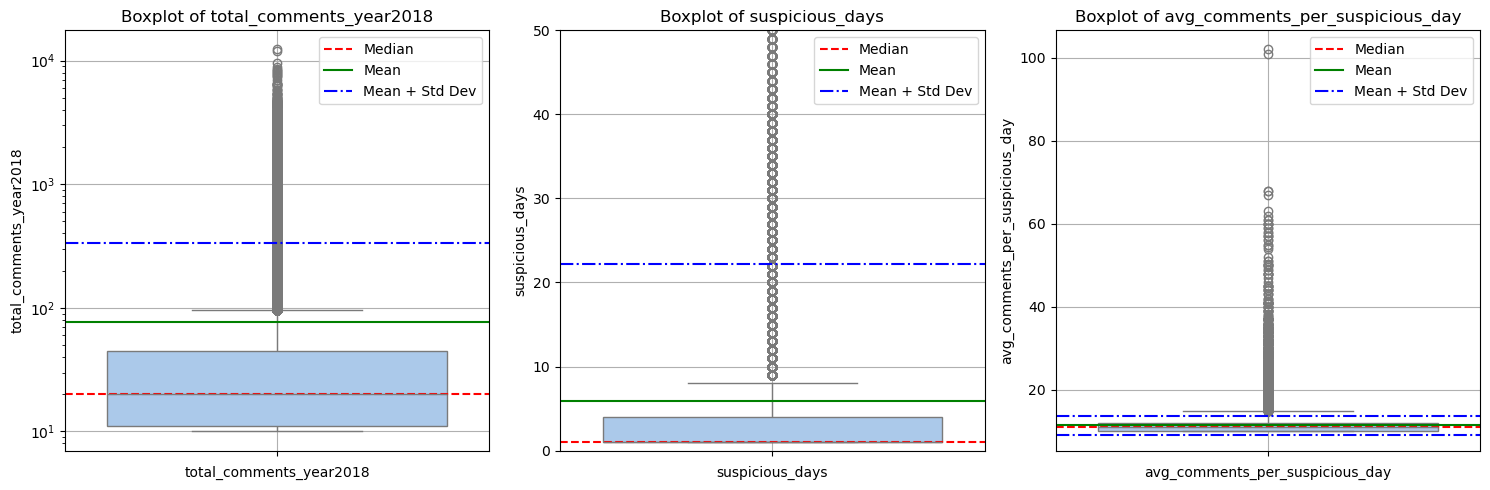

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the columns for plotting
cols_to_plot = ['total_comments_year2018', 'suspicious_days', 'avg_comments_per_suspicious_day']

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Iterate over columns and create boxplots
for i, col in enumerate(cols_to_plot):
    sns.boxplot(data=merged_data[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(col)

    # Calculate median, mean, and standard deviation
    median = merged_data[col].median()
    mean = merged_data[col].mean()
    std_dev = merged_data[col].std()

    # Add median, mean, and standard deviation lines
    axes[i].axhline(median, color='red', linestyle='--', label='Median')
    axes[i].axhline(mean, color='green', linestyle='-', label='Mean')
    axes[i].axhline(mean + std_dev, color='blue', linestyle='-.', label='Mean + Std Dev')
    axes[i].axhline(mean - std_dev, color='blue', linestyle='-.')

    # Add legend
    axes[i].legend()

    # Apply log scale if needed
    if col == 'total_comments_year2018':
        axes[i].set_yscale('log')

    # Zoom in on suspicious_days
    if col == 'suspicious_days':
        axes[i].set_ylim(0, 50)

    # Add grid lines
    axes[i].grid(True)

# Customize color palette
sns.set_palette("pastel")

plt.tight_layout()
plt.show()


The stats on merged_data tell us that among the suspicious actions detected with our filter, we see that in average these users overtake the limit of 10 different videos commented 6 (5.9) times in 2018. We have 25 % of the users which commented more than 4 times in 2018. This means some outliers pull the average up, for example the max is 357 days in the year were suspicious behavior was detected for an a author/user. 
The max number of comment done in a year (still counting only days were it was above 10 different videos commented (remember how this dataset was built)) by a single user/author is 12 328, while the average is 76.23 while only 25% of users are above a total number of comments in a year of 45. This means that the average number of comments is also biased by outliers which are very high. 

In the box plot grey circles are outliers. The boxplots reveal a right-skewed distribution for all three metrics. This indicates that a small number of users contribute a disproportionately large number of comments, experience extended periods of suspicious activity, and/or comment excessively during suspicious periods.


Now that we have the data for the number of comments per days we can put them in different categories. 


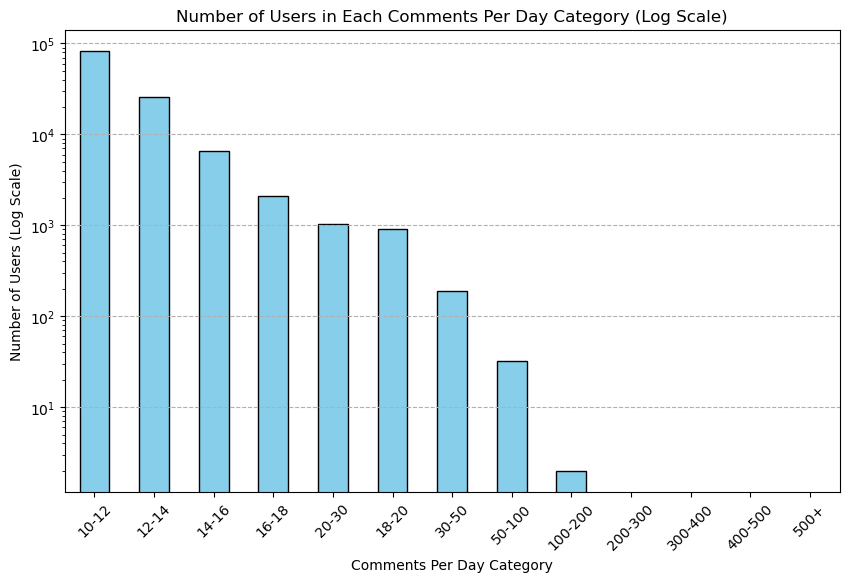

Counts of users in each comments per day category:
comments_per_day_category
10-12      83168
12-14      25943
14-16       6518
16-18       2106
20-30       1035
18-20        914
30-50        188
50-100        32
100-200        2
200-300        0
300-400        0
400-500        0
500+           0
Name: count, dtype: int64


In [93]:
# # Step 5: Define categories for the number of comments per day
# # Using the bins and labels you provided
bins = [10, 12, 14, 16, 18, 20, 30, 50, 100, 200, 300, 400, 500, 1000]
labels = ['10-12', '12-14', '14-16', '16-18', '18-20', '20-30', '30-50', '50-100', '100-200', '200-300', '300-400', '400-500', '500+']

merged_data['comments_per_day_category'] = pd.cut(merged_data['avg_comments_per_suspicious_day'], bins=bins, labels=labels, right=False)
# # Step 6: Display the final table with categories
merged_data.head(20)

# Step 7: Plot the number of users in each category using a bar chart with logarithmic scale
category_counts = merged_data['comments_per_day_category'].value_counts()

# Plot the bar chart with logarithmic scale on the y-axis
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Number of Users in Each Comments Per Day Category (Log Scale)')
plt.xlabel('Comments Per Day Category')
plt.ylabel('Number of Users (Log Scale)')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--')
plt.show()

# Step 8: Print the counts for each category
print("Counts of users in each comments per day category:")
print(category_counts) 

The graph shows a right-skewed distribution, meaning that most users fall into the lower categories (10-12, 12-14, etc.), while fewer users are in the higher categories. This is just an other way to visualize the box plot from above of avg_comments_per_suspicious_day, it confirms our previous conclusion. 

Now we are ready to see if there is a link between having a higher number of avg_comments_per_suspicious_day versus having a shorter 'lifetime', which could potentially mean that these bots were patched somehow. Many other reasons are possible but let's first see if we have a link. 

In [127]:
merged_data.head(10)

,author,total_comments_year2018,suspicious_days,avg_comments_per_suspicious_day,comments_per_day_category
0,1695,96,9,10.666667,10-12
1,8417,11,1,11.000000,10-12
2,9490,33,3,11.000000,10-12
3,11164,11,1,11.000000,10-12
4,17554,22,2,11.000000,10-12
5,41558,23,2,11.500000,10-12
6,48112,10,1,10.000000,10-12
7,59284,95,9,10.555556,10-12
8,59321,10,1,10.000000,10-12
9,59588,20,2,10.000000,10-12


In [126]:
bot_activity.head(10)


,min,max,lifetime_days,lifetime_category
author,,,,
1695,2018-04-21,2018-11-06,200,180-210 days
8417,2018-06-12,2018-06-12,1,1 day
9490,2018-05-04,2018-07-27,85,60-90 days
11164,2018-05-25,2018-05-25,1,1 day
17554,2018-07-25,2018-08-10,17,10-20 days
41558,2018-10-31,2018-12-13,44,30-60 days
48112,2018-02-25,2018-02-25,1,1 day
59284,2018-05-14,2018-10-15,155,150-180 days
59321,2018-12-18,2018-12-18,1,1 day


In [128]:
# Merge the DataFrames on 'author'
final_merge = merged_data.merge(bot_activity, on='author')

# Create the cross-tabulation
category_combination_counts = pd.crosstab(final_merge['lifetime_category'], final_merge['comments_per_day_category'])

In [130]:
category_combination_counts.head(100)

comments_per_day_category,10-12,12-14,14-16,16-18,18-20,20-30,30-50,50-100,100-200
lifetime_category,,,,,,,,,
1 day,43776,10749,3267,1154,511,611,130,27,2
2-3 days,1527,696,270,101,60,74,13,0,0
3-5 days,1537,659,215,84,39,36,2,1,0
5-10 days,2845,1054,252,86,46,33,2,0,0
10-20 days,3662,1338,279,90,37,29,5,3,0
20-30 days,2896,1046,232,64,25,21,1,0,0
30-60 days,5964,2021,429,102,43,36,1,0,0
60-90 days,4055,1413,263,82,35,27,6,0,0
90-120 days,3171,1071,202,54,11,22,5,0,0


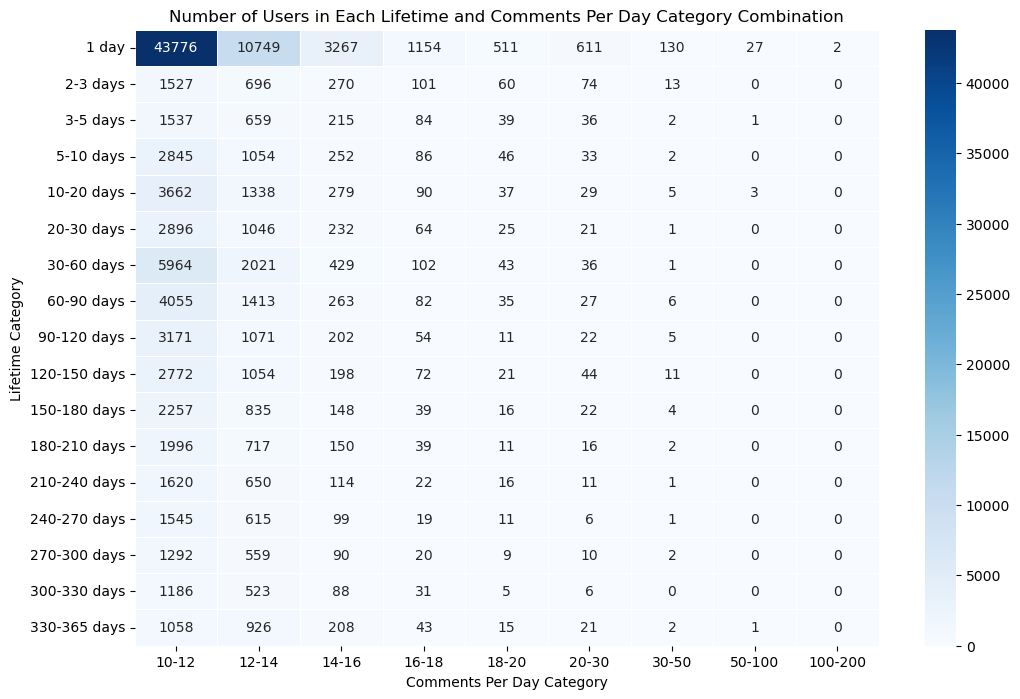

In [131]:
# Visualize the cross-tabulation as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(category_combination_counts, annot=True, fmt='d', cmap='Blues', linewidths=.5)
plt.title('Number of Users in Each Lifetime and Comments Per Day Category Combination')
plt.xlabel('Comments Per Day Category')
plt.ylabel('Lifetime Category')
plt.show()

The heatmap reveals a right-skewed distribution of bot behavior. Most bots exhibit short lifespans and low comment activity, while a smaller subset is characterized by longer lifespans and higher activity. This suggests that a significant portion of bots engage in short-lived, intense campaigns, while others maintain a more sustained, low-level presence.

***Analyzing Seasonal Trends in Bot Activity***

In this analysis, we aim to uncover potential seasonal patterns in bot activity based on the frequency of comments on videos. Here are the key aspects we’ll focus on:

**Weekly Trends**: Are there specific days of the week when bots are more active? For example, do they comment more frequently on weekends, like Saturdays?

**Seasonal Trends:**

*Activity by Season*: Are bots more or less active during certain times of the year? For instance, is there a drop in activity during the summer?

*Influence of Video Releases*: If we observe reduced activity in certain seasons, could it be related to fewer video releases during those times? This can be examined later in the project using the full dataset, which would include video release dates to help correlate bot activity with video availability.

*Variation in Bot Behavior Across Seasons*: Do different bots exhibit distinct seasonal behaviors? For example, some bots might be consistently active throughout the year, while others could show peaks and dips in specific seasons. Analyzing these patterns could help categorize bot behavior based on seasonality.

This approach will provide insights into both the temporal and behavioral aspects of bot activity across time.

Now it would be nice to see if suspicious users that we classified as bots so the one commenting on more than 10 videos per days are focusing on a certain type of category, for instance on gaming ? Because from the dataset  1 we know already the repartition of comments from bots per category. But what types (focus on watching, on commenting, on liking?, what type of frequency, everyday comesback and comments videos, are they commenting the same videos over and over everyday ?) of bots do theses videos categories have in general ? Are bots focusing on videos from a single channel ? 